
# Named Entity Recognition using LSTMs with Keras

###  Importing Modules

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [22]:
data = pd.read_csv("dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [23]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [24]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [25]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Retrieving Sentences and Corresponsing Tags

In [26]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [27]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [28]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

###  Mappings between Sentences and Tags

In [29]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [30]:
word2idx

{'damages': 1,
 'location': 2,
 'Burn': 3,
 'conflict-resolution': 4,
 'Salman': 5,
 'boundaries': 6,
 'increases': 7,
 'nationally': 8,
 'script': 9,
 'Challenges': 10,
 'Shahawar': 11,
 'land-use': 12,
 'inflicted': 13,
 'percent': 14,
 'Notari': 15,
 'Clerq': 16,
 'gall': 17,
 'Disasters': 18,
 '1500': 19,
 '1631': 20,
 '463': 21,
 'Sekou': 22,
 'CIS': 23,
 'Erin': 24,
 'gruesome': 25,
 'Gatlin': 26,
 'faiths': 27,
 '2,46,000': 28,
 'Illinois': 29,
 'Phukphasuk': 30,
 'Whales': 31,
 'steel': 32,
 'ecology': 33,
 'Christman': 34,
 'recoverable': 35,
 'preoccupied': 36,
 'sought': 37,
 'seizing': 38,
 'Jebaliya': 39,
 'injection': 40,
 'Meadowbrook': 41,
 'materials': 42,
 'Bernal': 43,
 'longest': 44,
 'Housedog': 45,
 'sooner': 46,
 'Ghanaian': 47,
 'Mexicali': 48,
 'video-conferencing': 49,
 'rebates': 50,
 'Chitigov': 51,
 'Bakwa': 52,
 'Coca': 53,
 'Hajime': 54,
 'unlicensed': 55,
 'Qiyue': 56,
 'foundations': 57,
 'sessions': 58,
 'picnicking': 59,
 'Yorker': 60,
 'blew': 61,
 '

### Padding Input Sentences and Creating Train/Test Splits

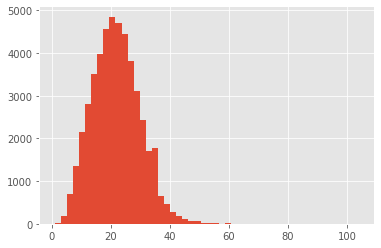

In [31]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

###  Building and Compiling a Bidirectional LSTM Model

In [34]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [35]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy",])

###  Training the Model

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKerasTF

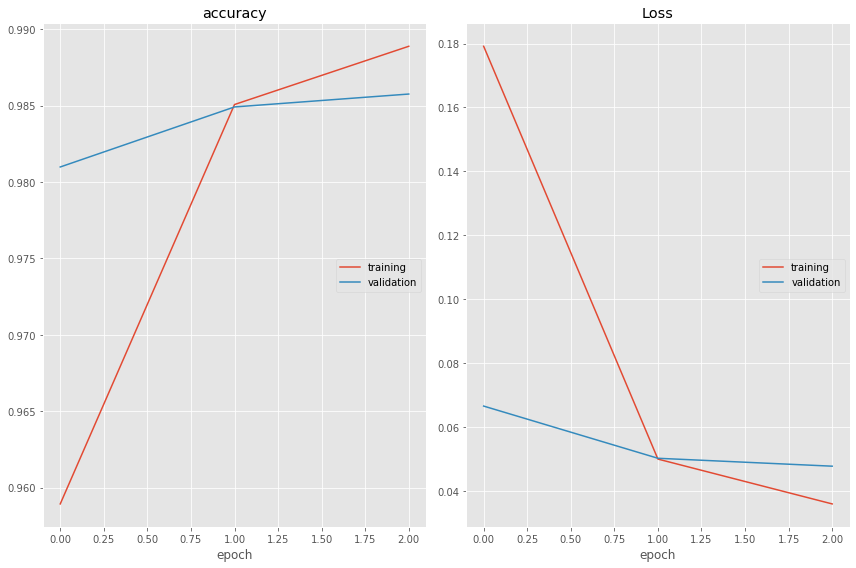

accuracy
	training         	 (min:    0.959, max:    0.989, cur:    0.989)
	validation       	 (min:    0.981, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.036, max:    0.179, cur:    0.036)
	validation       	 (min:    0.048, max:    0.067, cur:    0.048)

Epoch 00003: val_loss improved from 0.05033 to 0.04786, saving model to model_weights.h5
1199/1199 [==============================] - 150s 125ms/step - loss: 0.0361 - accuracy: 0.9889 - val_loss: 0.0479 - val_accuracy: 0.9858
Wall time: 8min 38s


In [38]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min', metrics=["accuracy","val_accuracy"])

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesKerasTF(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

### Task 8: Evaluate Named Entity Recognition Model

In [39]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 5s 18ms/step - loss: 0.0479 - accuracy: 0.9858


[0.04785611107945442, 0.9857589602470398]

In [40]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
At             O	O
least          O	O
eight          O	O
people         O	O
have           O	O
been           O	O
killed         O	O
in             O	O
the            O	O
fighting       O	O
.              O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens         O	O
sirens    